In [10]:
try:
	import google.colab
	IN_COLAB = True
except ImportError:
	IN_COLAB = False

import os
IN_LOCAL = os.getenv("IN_LOCAL") == '1'

if IN_COLAB:
	!pip install scikit-learn matplotlib numpy pandas torch pytorch-lightning torchvision tensorboardx tensorflow
	!pip install torch-fidelity
	!pip install gradio

elif IN_LOCAL:
	# !cmd doesn't work in docker
	!pip install -r requirements.txt


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import pandas as pd
import numpy as np
%matplotlib inline
	# avoid rare bugs when image won't plot
import matplotlib.pyplot as plt
import seaborn as sns

import pytorch_lightning as pl
from pytorch_lightning import Trainer
#from lightning.pytorch.loggers import WandbLogger

import wandb
wandb_api_key = os.getenv("WANDB_API_KEY")
wandb_username = os.getenv("WANDB_USERNAME")

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader
from torchvision import transforms

from IPython.display import display
	# make it not fail in terminal execution
#from typing import override
	# docker is not in python >=3.12
import os.path
from types import SimpleNamespace
	# make dict to class

from torchvision import datasets
from torchvision.transforms.v2 import CenterCrop
from sklearn.model_selection import train_test_split

from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

from diffusers import DDPMPipeline
from diffusers import DDPMScheduler
import torchvision
from diffusers import LMSDiscreteScheduler, EulerDiscreteScheduler, EulerAncestralDiscreteScheduler, DPMSolverMultistepScheduler

import gradio as gr

## Hyperparameter configuration, set random states

In [ ]:
# hyperparameters
random_state = 42 # random state
test_val_size = 0.2 # size of test and validation together to the whole dataset
test_size = 0.5 # size of test to test and validation together
num_workers = 2 # number of workers for data loading
batch_size = 128
score_batch_size = 12
assert score_batch_size // 2 > 5
assert score_batch_size % 2 == 0
score_batch_count = 6
height = 32
width = height

is_celeba_on = True # celebA is needed or not
eval_only = True
is_score_on = False
visualize_and_analyze = False

torch.set_float32_matmul_precision('medium')
	# Faster exec. on newer GPUs

In [13]:
# Fix random early on
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed_all(random_state);

## Data modules

### Custom dataset omitting targets

In [ ]:
class NoTargetDataset(torch.utils.data.Dataset):
	def __init__(self, original_dataset):
		super().__init__()
		self.original_dataset = original_dataset

	# override
	def __len__(self):
		return len(self.original_dataset)

	# override
	def __getitem__(self, idx):
		image, _ = self.original_dataset[idx]
		return image

### Flowers Module

In [15]:
# Flowers data module
class FlowersDataModule(pl.LightningDataModule):
	def __init__(self, batch_size):
		super().__init__()
		self.name = "Flowers102"
		self.batch_size = batch_size
		self.base_transform = transforms.Compose([
			transforms.CenterCrop(500),
			transforms.Resize(height),
			transforms.ToTensor(),
			transforms.Lambda(lambda img: (img - 0.5) * 2)
		])
		def permutate_last_three(tensor):
			if tensor.ndim == 3:
				return tensor.permute(1, 2, 0)
			assert tensor.ndim == 4
			return tensor.permute(0, 2, 3, 1)
		self.reverse_transform = transforms.Compose([
			transforms.Lambda(lambda img: img.cpu()),
			transforms.Lambda(lambda img: img.clip(-1, 1)),
			transforms.Lambda(lambda img: img / 2 + 0.5),
			transforms.Lambda(lambda img: permutate_last_three(img).numpy() * 255),
			transforms.Lambda(lambda img: img.astype(np.uint8))
		])

		self.dataset_notransform = NoTargetDataset(torch.utils.data.ConcatDataset([
			datasets.Flowers102('./data', download=True, split="train"),
			datasets.Flowers102('./data', download=True, split="test"),
			datasets.Flowers102('./data', download=True, split="val")
		]))
		self.dataset = NoTargetDataset(torch.utils.data.ConcatDataset([
			datasets.Flowers102('./data', download=True, split="train", transform=self.base_transform),
			datasets.Flowers102('./data', download=True, split="test", transform=self.base_transform),
			datasets.Flowers102('./data', download=True, split="val", transform=self.base_transform)
		]))
		self.input_shape = tuple(self.dataset[0].shape)

	# override
	def setup(self, stage=None):
		train, test_val = train_test_split(self.dataset, test_size=test_val_size, random_state=random_state)
		test, val = train_test_split(test_val, test_size=test_size, random_state=random_state)
		self.train_dataset = train
		self.val_dataset = val
		self.test_dataset = test

	# override
	def train_dataloader(self):
		return torch.utils.data.DataLoader(
			self.train_dataset,
			batch_size=self.batch_size,
			num_workers=num_workers,
			pin_memory=True,
			drop_last=True,
			shuffle=False,
			persistent_workers=True
				# avoid recreating after every fast epoch
		)

	# override
	def val_dataloader(self):
		return torch.utils.data.DataLoader(
			self.val_dataset,
			batch_size=self.batch_size,
			num_workers=num_workers,
			pin_memory=True,
			drop_last=True,
			shuffle=False,
			persistent_workers=True
		)

	# override
	def test_dataloader(self):
		return DataLoader(
			self.test_dataset,
			batch_size=self.batch_size,
			num_workers=num_workers,
			pin_memory=True,
			drop_last=True,
			shuffle=False,
			persistent_workers=True
		)

### CelebA Module

In [16]:
# Celeba data module
class CelebaDataModule(pl.LightningDataModule):
	def __init__(self, batch_size, len_flowers_dataset):
		super().__init__()
		self.name = "CelebA"
		self.batch_size = batch_size
		self.base_transform = transforms.Compose([
			transforms.CenterCrop(178),
			transforms.Resize(height),
			transforms.ToTensor(),
			transforms.Lambda(lambda img: (img - 0.5) * 2)
		])
		def permutate_last_three(tensor):
			if tensor.ndim == 3:
				return tensor.permute(1, 2, 0)
			assert tensor.ndim == 4
			return tensor.permute(0, 2, 3, 1)
		self.reverse_transform = transforms.Compose([
			transforms.Lambda(lambda img: img.cpu()),
			transforms.Lambda(lambda img: img.clip(-1, 1)),
			transforms.Lambda(lambda img: img / 2 + 0.5),
			transforms.Lambda(lambda img: permutate_last_three(img).numpy() * 255),
			transforms.Lambda(lambda img: img.astype(np.uint8))
		])

		# To compare the model on a different dataset it should be the same size (currently 8k vs 200k)
		self.dataset_notransform = NoTargetDataset(torch.utils.data.Subset(
			datasets.CelebA('./data', download=True, split="all"),
			np.random.choice(len_flowers_dataset, len_flowers_dataset, replace=False)
		))
		self.dataset = NoTargetDataset(torch.utils.data.Subset(
			datasets.CelebA('./data', download=True, split="all", transform=self.base_transform),
			np.random.choice(len_flowers_dataset, len_flowers_dataset, replace=False)
		))
		self.input_shape = tuple(self.dataset[0].shape)
	
	# override
	def setup(self, stage=None):
		train, test_val = train_test_split(self.dataset, test_size=test_val_size, random_state=random_state)
		test, val = train_test_split(test_val, test_size=test_size, random_state=random_state)
		self.train_dataset = train
		self.val_dataset = val
		self.test_dataset = test
	
	# override
	def train_dataloader(self):
		return torch.utils.data.DataLoader(
			self.train_dataset,
			batch_size=self.batch_size,
			num_workers=num_workers,
			pin_memory=True,
			drop_last=True,
			shuffle=False,
			persistent_workers=True
				# avoid recreating after every fast epoch
		)
	
	# override
	def val_dataloader(self):
		return torch.utils.data.DataLoader(
			self.val_dataset,
			batch_size=self.batch_size,
			num_workers=num_workers,
			pin_memory=True,
			drop_last=True,
			shuffle=False,
			persistent_workers=True
		)

	# override
	def test_dataloader(self):
		return DataLoader(
			self.test_dataset,
			batch_size=self.batch_size,
			num_workers=num_workers,
			pin_memory=True,
			drop_last=True,
			shuffle=False,
			persistent_workers=True
		)

## DataModule creation

In [17]:
# Create data module instances
flowers_dm = FlowersDataModule(batch_size)
flowers_dm.prepare_data()
flowers_dm.setup()

if is_celeba_on:
	celeba_dm = CelebaDataModule(batch_size, len(flowers_dm.dataset))
	celeba_dm.prepare_data()
	celeba_dm.setup()

Files already downloaded and verified
Files already downloaded and verified


## Data visualization

In [10]:
# Show sizes of images
def analyze_size(imgs, text, cols=["height", "width", "channels"]):
	sizes = pd.DataFrame([np.array(img).shape for img in imgs])
	sizes.columns = cols
	grouped_df = sizes.groupby(cols).size().reset_index(name='count')
	display(grouped_df.head())
	print(text, "min height", sizes["height"].min())
	print(text, "min width", sizes["width"].min())

if visualize_and_analyze:
	analyze_size(flowers_dm.dataset_notransform, flowers_dm.name)
	if is_celeba_on:
		analyze_size(celeba_dm.dataset_notransform, celeba_dm.name)

,height,width,channels,count
0,500,500,3,70
1,500,501,3,2
2,500,502,3,10
3,500,503,3,10
4,500,504,3,11


Flowers102 min height 500
Flowers102 min width 500


,height,width,channels,count
0,218,178,3,8189


CelebA min height 218
CelebA min width 178


In [19]:
# Show sizes of transformed images
def analyze_transformed(dataset, text):
	analyze_size(dataset, text, ["channels", "height", "width"])
	images = np.array([np.array(img) for img in dataset])
	return images

if visualize_and_analyze:
	flower_tensors = analyze_transformed(flowers_dm.dataset, flowers_dm.name)
	if is_celeba_on:
		celeba_tensors = analyze_transformed(celeba_dm.dataset, celeba_dm.name)

,channels,height,width,count
0,3,64,64,8189


Flowers102 min height 64
Flowers102 min width 64


,channels,height,width,count
0,3,64,64,8189


CelebA min height 64
CelebA min width 64


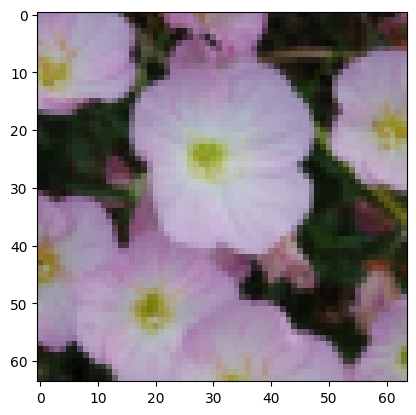

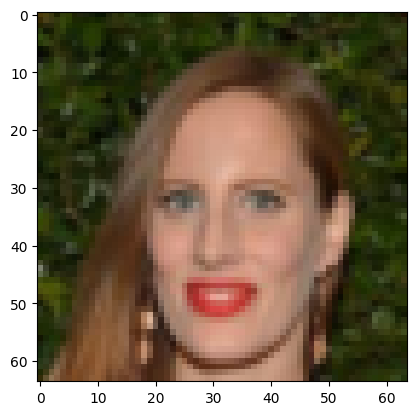

In [20]:
# Transformed image visualization

if visualize_and_analyze:
	plt.imshow(flowers_dm.reverse_transform(flowers_dm.dataset[0]))
	plt.figure()
	if is_celeba_on:
		plt.imshow(celeba_dm.reverse_transform(celeba_dm.dataset[0]))

## Data analysis

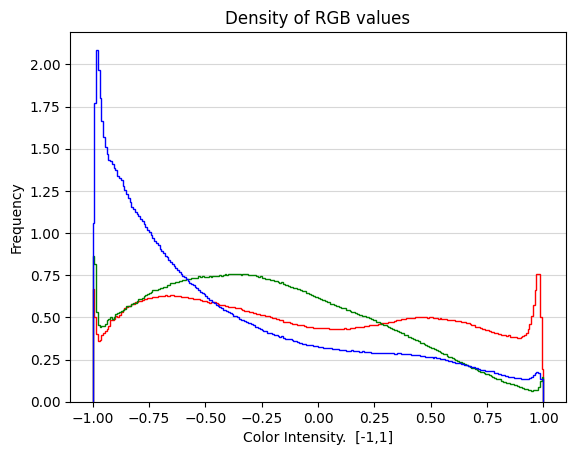

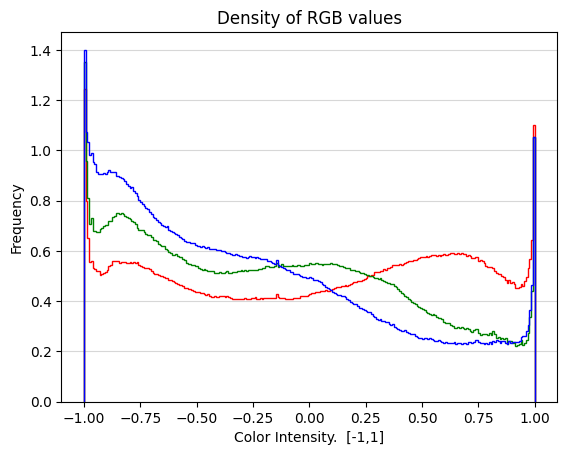

In [21]:
# Distribution of (normalized) pixels
# [-1,1] range expected
def img_histogram(data):
	for i, color in enumerate(["red", "green", "blue"]):
		plt.hist(data[:, i, :, :].flatten(), bins=256, range=(-1, 1), color=color, histtype=u'step', density=True)
	plt.title('Density of RGB values')
	plt.xlabel('Color Intensity.  [-1,1]')
	plt.ylabel('Frequency')
	plt.grid(axis='y', alpha=0.5)
	plt.show()

if visualize_and_analyze:
	img_histogram(flower_tensors)
	plt.figure()
	if is_celeba_on:
		img_histogram(celeba_tensors)

In [22]:
# split tensor data to train, test, val (only for plot)
def split(dataset):
	train, test = train_test_split(dataset, test_size=test_val_size, random_state=42)
	test, val = train_test_split(test, test_size=test_size, random_state=42)
	print(train.shape)
	print(test.shape)
	print(val.shape)
	return train, test, val

if visualize_and_analyze:
	flower_train, flower_test, flower_val = split(flower_tensors)
	if is_celeba_on:
		celeba_train, celeba_test, celeba_val = split(celeba_tensors)

(6551, 3, 64, 64)
(819, 3, 64, 64)
(819, 3, 64, 64)
(6551, 3, 64, 64)
(819, 3, 64, 64)
(819, 3, 64, 64)


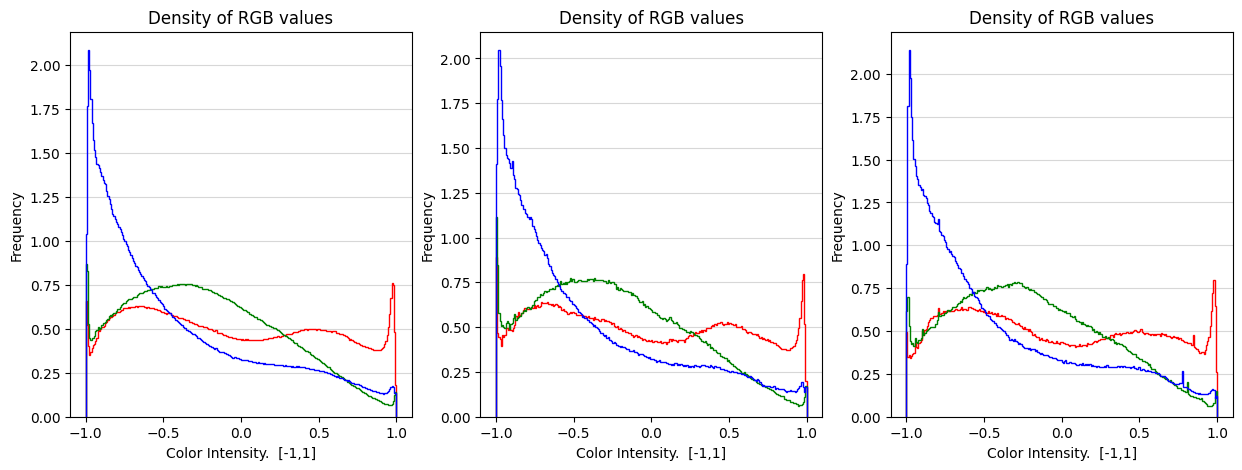

<Figure size 640x480 with 0 Axes>

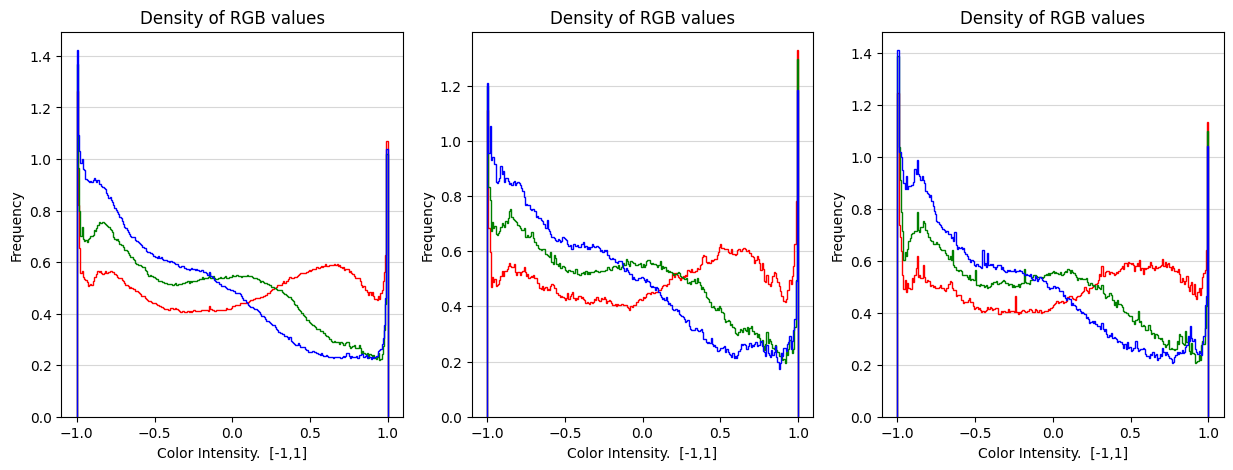

In [23]:
# Check if distribution is similar between train, test, val
def split_histogram(train, test, val):
	fig, axs = plt.subplots(1, 3, figsize=(15, 5))
	for idx, dataset in enumerate([train, test, val]):
		for i, color in enumerate(["red", "green", "blue"]):
			axs[idx].hist(dataset[:, i, :, :].flatten(), bins=256, range=(-1, 1), color=color, histtype=u'step', density=True)
		axs[idx].set_title('Density of RGB values') # can't use existing function because it's not .title 🙃
		axs[idx].set_xlabel('Color Intensity.  [-1,1]') # ...
		axs[idx].set_ylabel('Frequency') # ...
		axs[idx].grid(axis='y', alpha=0.5)
	plt.show()

if visualize_and_analyze:
	split_histogram(flower_train, flower_test, flower_val)
	plt.figure()
	if is_celeba_on:
		split_histogram(celeba_train, celeba_test, celeba_val)

In [24]:
if visualize_and_analyze:
	del flower_tensors
	del flower_train, flower_test, flower_val
	if is_celeba_on:
		del celeba_tensors
		del celeba_train, celeba_test, celeba_val

# Metrics

In [66]:
# Avoids normalization into [-1,1]
def to_tensor_image(numarr, normalize=False):
	t = torch.from_numpy(numarr)
	img = t.permute(0, 3, 1, 2)
	if normalize:
		img = img / 255 * 2 - 1
	return img

In [66]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

# Higher is better. The score is calculated on random splits of the images such that both a mean and standard deviation of the score are returned. 
def inception(get_images, batch_count=score_batch_count):
	# Calculate inception in batches: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint
	inception_scores = []
	for _ in range(batch_count):
		inception = InceptionScore().cuda()
			# [0-255] range expected: https://lightning.ai/docs/torchmetrics/stable/image/inception_score.html
		inception.update(get_images().cuda())
		inception_score = inception.compute()

		inception_scores.append(inception_score)
	return torch.tensor(inception_scores).mean(dim=0)

# 0 is the best.
def fid(dm, get_images, batch_count=score_batch_count, batch_size=score_batch_size):
	assert batch_count <= len(dm.test_dataloader())

	fid_scores = []
	# Takes too much time for non batch run
	# batch_size can't be large otherwise OOM
	for i, batch in enumerate(dm.test_dataloader()):
		if i == batch_count:
			break
		assert batch.shape[0] >= batch_size
		batch_notransform = to_tensor_image(dm.reverse_transform(batch))[:batch_size]
		
		fid = FrechetInceptionDistance(feature=64).cuda()
			# [0-255] range expected: https://lightning.ai/docs/torchmetrics/stable/image/frechet_inception_distance.html
		fid.update(batch_notransform.cuda(), real=True)
		fid.update(get_images().cuda(), real=False)
		fid_score = fid.compute()

		fid_scores.append(fid_score)
	return torch.tensor(fid_scores).mean(dim=0)

# Baseline

### Random image baseline + metric eval

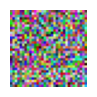

In [ ]:
random_images = torch.randint(0, 255, (3, height, width), dtype=torch.uint8)
plt.figure(figsize=(1, 1))
plt.imshow(random_images.view(height, width, 3))
plt.axis('off');

In [ ]:
if is_score_on:
	fid_score = fid(
		flowers_dm,
		lambda: torch.randint(0, 255+1, (score_batch_size, 3, height, width), dtype=torch.uint8, device='cuda')
	)
	print(f"FID: {fid_score}")
	print(f"FID: {fid_score}")

	inception_score = inception(
		lambda: torch.randint(0, 255+1, (score_batch_size, 3, height, width), dtype=torch.uint8, device='cuda')
	)
	print(f"Inception (mean, std): {inception_score}")

FID: 50.470279693603516
FID: 50.470279693603516
Inception (mean, std): tensor([1.0844, 0.0582])


### Implement and train VAE + metric eval

In [20]:
# https://pytorch-lightning.readthedocs.io/en/0.10.0/lightning_module.html
class VAE(pl.LightningModule):
	def __init__(self, input_shape, latent_size, optimizer_name, learning_rate):
		super().__init__()

		img_channel = input_shape[0]

		# Log hyperparameters
		self.save_hyperparameters()
		self.optimizer_name = optimizer_name
		self.learning_rate = learning_rate
		self.L = latent_size
	
		self.enc = torch.nn.Sequential(
			torch.nn.Conv2d(in_channels=img_channel, out_channels=32, kernel_size=4, stride=2, padding=1),
			torch.nn.ReLU(),

			torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1),
			torch.nn.ReLU(),

			torch.nn.Flatten()
		)

		flatten_size = self._shape_after_feature_extraction(input_shape)
		self.mu = torch.nn.Linear(in_features=flatten_size, out_features=self.L)
		self.log_var = torch.nn.Linear(in_features=flatten_size, out_features=self.L)
			# variance can't be negative

		last_conv_size = int(np.sqrt(flatten_size / 32))
		self.dec = torch.nn.Sequential(
			torch.nn.Linear(in_features=self.L, out_features=flatten_size),
			torch.nn.ReLU(),

			torch.nn.Unflatten(dim=1, unflattened_size=(32, last_conv_size, last_conv_size)),
				# dim 1: batches

			torch.nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1),
			torch.nn.ReLU(),

			torch.nn.ConvTranspose2d(in_channels=32, out_channels=img_channel, kernel_size=4, stride=2, padding=1),
			# no relu, batchnorm!
			torch.nn.Tanh()
				# Image domain is [-1,1]
		)

	''' Gives the size of flattened layer '''
	def _shape_after_feature_extraction(self, shape):
		batch_size = 1
		input = torch.rand(batch_size, *shape)
		flattened = self.enc(torch.autograd.Variable(input))
		return flattened.data.view(batch_size, -1).size(1)

	def encode(self, x):
		out = self.enc(x)
		mu = self.mu(out)
		lv = self.log_var(out)
		return mu, lv

	def decode(self, z):
		x = self.dec(z)
		return x

	# override
	def forward(self, x):
		mu, lv = self.encode(x)
		z = mu + torch.randn_like(lv) * torch.exp(lv)
		x_reconstructed = self.decode(z)

		return x_reconstructed, mu, lv

	def any_step(self, batch, batch_idx, phase):
		batch_reconstructed, mu, lv = self(batch)

		KL = torch.sum((mu**2 + torch.exp(lv) - 1 - lv) * .5)
		loss = torch.sum((batch - batch_reconstructed)**2) + KL

		if phase == "train":
			self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
		elif phase == "val":
			self.log('val_loss', loss, prog_bar=True)
		else:
			self.log('test_loss', loss, prog_bar=True)

		return loss
		
	# override
	def training_step(self, batch, batch_idx):
		return self.any_step(batch, batch_idx, "train")
	# override
	def validation_step(self, batch, batch_idx):
		return self.any_step(batch, batch_idx, "val")
	# override
	def test_step(self, batch, batch_idx):
		return self.any_step(batch, batch_idx, "test")
	
	# override
	def configure_optimizers(self):
		if self.optimizer_name == "sgd":
			optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate, momentum=0.9)
		elif self.optimizer_name == "adamw":
			optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=1e-4)
			optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
		return optimizer

def get_vae(dm, model_name, config):
	if eval_only and os.path.isfile(f"models/{model_name}.ckpt"):
		model = VAE.load_from_checkpoint(f"models/{model_name}.ckpt", batch_size=batch_size)
			# https://lightning.ai/docs/pytorch/latest/common/lightning_module.html#load-from-checkpoint
	else:	
		model = VAE(dm.input_shape, config.latent_size, config.optimizer_name, config.learning_rate)

		trainer = pl.Trainer(
			max_epochs=config.epoch,
			precision="16-mixed",
			accelerator="gpu",
			devices=1,
			callbacks=[
				pl.callbacks.ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min", dirpath=f'./models/', filename=model_name),
				pl.callbacks.EarlyStopping(monitor="val_loss", patience=config.early_stop_patience, verbose=False, mode="min")
			],
			#fast_dev_run = True,
			log_every_n_steps=1
		)
		trainer.fit(model, dm)
		trainer.test(dataloaders=dm.test_dataloader())

	model.eval()

	return model
	
config = SimpleNamespace(**{
	"latent_size": 2,
	"optimizer_name": "adamw",
	"learning_rate": 0.001,
	"epoch": 200,
	"early_stop_patience": 10,
})

flowers_vae = get_vae(flowers_dm, "vae-flowers", config)
if is_celeba_on:
	celeba_vae = get_vae(celeba_dm, "vae-celeba", config)

In [21]:
def vae_generate_batch(model, dm, batch_size):
	z_random = torch.randn(batch_size, config.latent_size).to("cuda")
	with torch.no_grad():
		generated_transformed = model.decode(z_random)
		generated = dm.reverse_transform(generated_transformed)
	return generated

def vae_plot(model, dm, batch_size=5):
	generated = vae_generate_batch(model, dm, batch_size)

	f,ax = plt.subplots(1,batch_size)
	for i in range(batch_size):
		ax[i].imshow(generated[i])
		ax[i].axis('off')

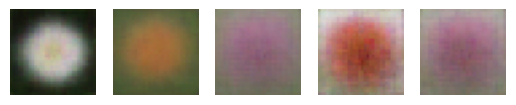

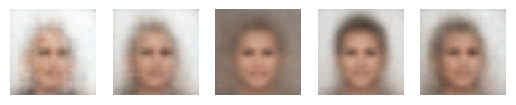

In [22]:
# Generated images from noises
if visualize_and_analyze:
	vae_plot(flowers_vae, flowers_dm)
	if is_celeba_on:
		vae_plot(celeba_vae, celeba_dm)

In [23]:
def vae_print_fid(model, dm):
	fid_score = fid(
		dm,
		lambda: to_tensor_image(vae_generate_batch(model, dm, score_batch_size))
	)
	print(f"FID: {fid_score}")

def vae_print_inception():
	def gen():
		imgs1 = to_tensor_image(vae_generate_batch(flowers_vae, flowers_dm, score_batch_size // 2))
		imgs2 = to_tensor_image(vae_generate_batch(celeba_vae, celeba_dm, score_batch_size // 2))
		imgs = torch.cat((imgs1, imgs2), dim=0)

		perm = torch.randperm(imgs.shape[0])
		imgs = imgs[perm]
		return imgs

	inception_score = inception(gen)
	print(f"Inception (mean, std): {inception_score}")

In [19]:
if is_score_on:
	vae_print_fid(flowers_vae, flowers_dm)
	if is_celeba_on:
		vae_print_fid(celeba_vae, celeba_dm)
		vae_print_inception()

FID: 3.2527053356170654
FID: 2.4564361572265625


c:\Users\asztr\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


Inception (mean, std): tensor([1.4691, 0.1964])


# Fine tune pretrained diffusion modell (DDPM)

In [26]:
# Wandb API helpers
def get_sweeps(project):
	api = wandb.Api()
	sweeps = api.project(project).sweeps()
	return sweeps

def get_best_run(project):
	last_sweep = get_sweeps(project)[0]
	return last_sweep.best_run(order='+summary_metrics.val_loss') # descending order

def get_run_model_path(run):
	run_artifact = run.logged_artifacts()[0]
	return f"artifacts/{run_artifact.name.replace(":", "-")}/{run_artifact.files()[0].name}"

DDPM: https://huggingface.co/docs/diffusers/api/pipelines/ddpm

UNET: https://huggingface.co/docs/diffusers/v0.31.0/en/api/models/unet2d#diffusers.UNet2DModel

Schedulers: https://huggingface.co/docs/diffusers/using-diffusers/schedulers

Usage: https://huggingface.co/learn/diffusion-course/en/unit2/2


In [ ]:
def diff_generate_with_steps(pipeline, dm, batch_size):
	pipeline = pipeline.to("cuda")

	diff_shape = (batch_size, pipeline.unet.config.in_channels, pipeline.unet.sample_size, pipeline.unet.sample_size)
	diff_random = torch.randn(diff_shape).to("cuda")

	diff_current = diff_random
	yield dm.reverse_transform(diff_current)
	scheduler = pipeline.scheduler
	for i, t in enumerate(scheduler.timesteps):
		model_input = scheduler.scale_model_input(diff_current, t)
			# Not every scheduler applies transform

		# Predict noise in t
		with torch.no_grad():
			noise_pred = pipeline.unet(model_input, t).sample
				# https://huggingface.co/docs/diffusers/en/api/models/unet2d#diffusers.models.unets.unet_2d.UNet2DOutput

		diff_current = scheduler.step(noise_pred, t, diff_current).prev_sample
			# https://huggingface.co/docs/diffusers/en/api/schedulers/overview#diffusers.schedulers.scheduling_utils.SchedulerOutput
		yield dm.reverse_transform(diff_current)

def diff_generate(pipeline, dm, batch_size=batch_size):
	return list(diff_generate_with_steps(pipeline, dm, batch_size))[-1] # we only need the generated image (the last step)

def diff_plot(batch_size=5, pipeline=DDPMPipeline.from_pretrained("google/ddpm-cifar10-32"), dm=flowers_dm): # No safetensor version
	imgs = diff_generate(pipeline, dm, batch_size)
	
	f,ax = plt.subplots(1, batch_size)
	for i in range(batch_size):
		ax[i].imshow(imgs[i])
		ax[i].axis('off')

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch C:\Users\asztr\.cache\huggingface\hub\models--google--ddpm-cifar10-32\snapshots\267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\asztr\.cache\huggingface\hub\models--google--ddpm-cifar10-32\snapshots\267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [ ]:
if visualize_and_analyze:
	diff_plot()

In [ ]:
from functools import partial
class DiffuseFineTuned(pl.LightningModule):
	def __init__(self, learning_rate, weight_decay, pipeline):
		super().__init__()
		self.save_hyperparameters()

		self.learning_rate = learning_rate
		self.weight_decay = weight_decay
		self.pipeline = pipeline.to("cuda")
		self.scheduler = self.pipeline.scheduler

	# override
	def forward(self, batch):
		noises = torch.randn(batch.shape).to("cuda")
		timesteps_random = torch.randint(0, self.scheduler.config.num_train_timesteps, (batch_size,)).to("cuda")
		batch_noisy = self.scheduler.add_noise(batch, noises, timesteps_random)
		noises_pred = self.pipeline.unet(batch_noisy, timesteps_random).sample

		return noises, noises_pred

	def T_step(self, batch, batch_idx, T, on_epoch=False, prog_bar=False):
		noises, noises_pred = self(batch)

		loss = torch.nn.functional.mse_loss(noises, noises_pred)
		self.log(f"{T}_loss", loss, on_epoch=on_epoch, prog_bar=prog_bar)
		return loss

	# override
	def training_step(self, batch, batch_idx):
		return self.T_step(batch, batch_idx, "train", on_epoch=True)

	# override
	def validation_step(self, batch, batch_idx):
		return self.T_step(batch, batch_idx, "val", on_epoch=True, prog_bar=True)

	# override
	def test_step(self, batch, batch_idx):
		return self.T_step(batch, batch_idx, "test", on_epoch=True)

	# override
	def configure_optimizers(self):
		# L2 regularizáció
		return torch.optim.AdamW(self.pipeline.unet.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

######

def train_diff(dm, model_name, config=None):
	project = f"dl-nhf-{model_name}"

	with wandb.init(config=config, project=project):
		config = wandb.config
		
		model = DiffuseFineTuned(config.learning_rate, config.weight_decay, DDPMPipeline.from_pretrained("google/ddpm-cifar10-32"))
		logger = pl.loggers.WandbLogger(project=project, log_model="all")
		trainer = pl.Trainer(
			max_epochs=config.epoch,
			precision="16-mixed",
				# 32 biten tárolva, de a lényeges számítások 16 biten
			accelerator="gpu",
			devices=1,
			logger=logger,
			callbacks=[
				pl.callbacks.ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min", dirpath=f'./models/{model_name}/',
					filename=f"{model_name}_{config.learning_rate}_{config.weight_decay}_{config.accumulate_grad_batches}"
				),
				pl.callbacks.EarlyStopping(monitor="val_loss", patience=config.early_stop_patience, verbose=False, mode="min")
			],
			accumulate_grad_batches=config.accumulate_grad_batches,
			#fast_dev_run = True,
			log_every_n_steps=1
		)
		trainer.fit(model, dm)
		trainer.test(ckpt_path='best', dataloaders=dm.test_dataloader())
		wandb.finish()
		return model

def get_diff_best_model(project):
	best_run = get_best_run(project)
	path = get_run_model_path(best_run)
	if not os.path.isfile(path):
		best_run.logged_artifacts()[0].download()
	model = DiffuseFineTuned.load_from_checkpoint(path)
	model.eval()
	return model

def get_diff(dm, model_name, sweep_config):
	project = f"dl-nhf-{model_name}"
	try:
		already_trained = len(get_sweeps(project)) != 0
	except Exception as e:
		already_trained = False

	if not(eval_only and already_trained):
		if eval_only:
			print("Eval only mode, but no trained diffusion model found! Training...")
		wandb.finish()
		sweep_id = wandb.sweep(sweep_config, project=project)
		wandb.agent(sweep_id, function=partial(train_diff, dm, model_name), count=1)
		wandb.finish()

	model = get_diff_best_model(project)

	return model

sweep_config = {
	"name": "dl-nhf-hyper",
	"method": "bayes",#"random",
	"metric": {
		"goal": "minimize",
		"name": "val_loss"
	},
	"parameters": {
		"learning_rate": { "values": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0] },
		"weight_decay": { "values": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0] },
		"epoch": { "values": [200] },
		"early_stop_patience": { "values": [30] },
		"accumulate_grad_batches": { "values": [2,5,10] },
	},
	# best_parameters: {
	# 	"learning_rate": { "values": [0.0001]},
	# 	"weight_decay": { "values": [1] },
	# 	"accumulate_grad_batches": { "values": [2] },
	# }
}

flowers_diff = get_diff(flowers_dm, "diff-flowers", sweep_config)
if is_celeba_on:
	celeba_diff = get_diff(celeba_dm, "diff-celeba", sweep_config)

wandb: Sorting runs by +summary_metrics.val_loss
c:\Users\asztr\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\core\saving.py:94: The state dict in 'artifacts/model-40y72itq-v0/model.ckpt' contains no parameters.
wandb: Sorting runs by +summary_metrics.val_loss
c:\Users\asztr\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\core\saving.py:94: The state dict in 'artifacts/model-lmmvoz3z-v0/model.ckpt' contains no parameters.


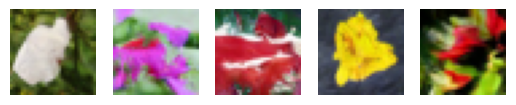

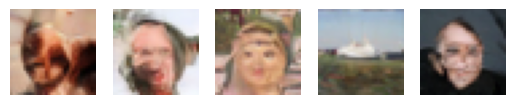

In [27]:
if visualize_and_analyze:
	diff_plot(pipeline=flowers_diff.pipeline, dm=flowers_dm)
	if is_celeba_on:
		diff_plot(pipeline=celeba_diff.pipeline, dm=celeba_dm)

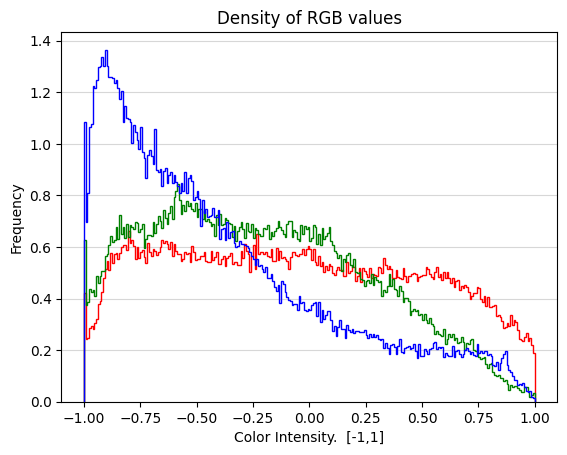

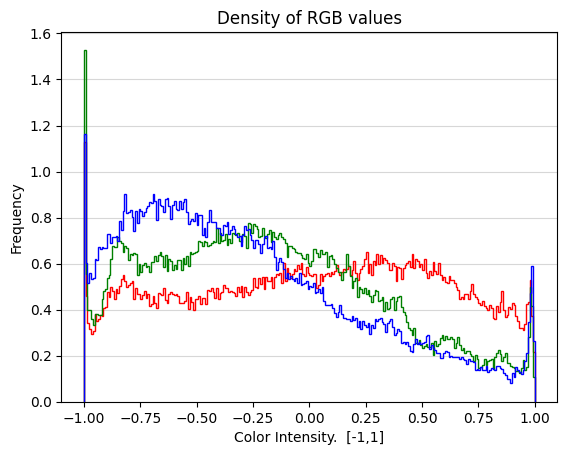

In [28]:
if visualize_and_analyze:
	flower_tensors = to_tensor_image(diff_generate(flowers_diff.pipeline, flowers_dm, batch_size), normalize=True)
	img_histogram(flower_tensors)
	if is_celeba_on:
		celeba_tensors = to_tensor_image(diff_generate(celeba_diff.pipeline, celeba_dm, batch_size), normalize=True)
		img_histogram(celeba_tensors)

In [29]:
def diff_print_fid(model, dm):
	fid_score = fid(
		dm,
		lambda: to_tensor_image(diff_generate(model.pipeline, dm, score_batch_size))
	)
	print(f"FID: {fid_score}")

def diff_print_inception():
	def gen():
		imgs1 = to_tensor_image(diff_generate(flowers_diff.pipeline, flowers_dm, score_batch_size // 2))
		imgs2 = to_tensor_image(diff_generate(celeba_diff.pipeline, celeba_dm, score_batch_size // 2))
		imgs = torch.cat((imgs1, imgs2), dim=0)

		perm = torch.randperm(imgs.shape[0])
		imgs = imgs[perm]
		return imgs

	inception_score = inception(gen)
	print(f"Inception (mean, std): {inception_score}")

In [30]:
if is_score_on:
	diff_print_fid(flowers_diff, flowers_dm)
	if is_celeba_on:
		diff_print_fid(celeba_diff, celeba_dm)
		diff_print_inception()

FID: 2.069375991821289
FID: 1.0349209308624268
Inception (mean, std): tensor([1.6420, 0.1707])


# UI for generation

In [ ]:
import time

gen_epochs = len(flowers_diff.pipeline.scheduler.timesteps)
generated_images_ce = []
generated_images_fl = []

def generate_image(model, dm):
	for noisy in diff_generate_with_steps(model.pipeline, dm, 1):
		yield noisy[0]

def get_image_by_index_ce(index):
	index -= 1
	if 0 <= index < len(generated_images_ce):
		return generated_images_ce[index]
	return None

def get_image_by_index_fl(index):
	index -= 1
	if 0 <= index < len(generated_images_fl):
		return generated_images_fl[index]
	return None

In [ ]:
with gr.Blocks() as generator_ui:
	with gr.Row(equal_height=True):
		gr.Markdown("# Flower Generator 🌸")
		gr.Markdown("# CelebA Generator 🧑‍🎄")
	with gr.Row(equal_height=True):
		fl_button = gr.Button("Generate", variant="primary")
		ce_button = gr.Button("Generate", variant="primary")
	with gr.Row(equal_height=True):
		fl_image = gr.Image(height=150, width=150)
		ce_image = gr.Image(height=150, width=150)
	with gr.Row(equal_height=True):
		fl_slider = gr.Slider(minimum=1, maximum=gen_epochs, step=1, label="Epochs", visible=True)
		ce_slider = gr.Slider(minimum=1, maximum=gen_epochs, step=1, label="Epochs", visible=True)

	def update_image_fl():
		global generated_images_fl
		generated_images_fl = []
		for new_image in generate_image(flowers_diff, flowers_dm):
			generated_images_fl.append(new_image)
			yield gr.update(value=new_image)

	def update_image_ce():
		global generated_images_ce
		generated_images_ce = []
		for new_image in generate_image(celeba_diff, celeba_dm):
			generated_images_ce.append(new_image)
			yield gr.update(value=new_image)

	fl_button.click(
		update_image_fl,
		inputs=[],
		outputs=fl_image
	)

	fl_slider.change(
		get_image_by_index_fl,
		inputs=fl_slider,
		outputs=fl_image,
		stream_every=1
	)

	ce_button.click(
		update_image_ce,
		inputs=[],
		outputs=ce_image
	)

	ce_slider.change(
		get_image_by_index_ce,
		inputs=ce_slider,
		outputs=ce_image,
		stream_every=1
	)

	generator_ui.css="""
		.gradio-container {
			display: flex;
			align-items: center;
			min_width: 800;
		}
		[class^="contain svelte-"] {
			min-width: 500px;
		}
	"""

	generator_ui.launch(share=True, debug=False, server_name='0.0.0.0', server_port=8887)

* Running on local URL:  http://0.0.0.0:8884

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
